# Supermarket Sales Dataset

Description:
* 1000 rows, 2 parent and 1 child features

Features:
* Branch, City, Customer type, Gender, Product line, Unit price, Month, Date, Time, Quantity, Tax 5%, Total, Payment

Selected parent features:
* Branch, Time

Selected child features:
* Total

Source: https://www.kaggle.com/aungpyaeap/supermarket-sales

In [1]:
import sys
sys.path.append("C:/Users/notes/grab")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
sm = pd.read_csv("../data/supermarket.csv")

In [116]:
sm.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [117]:
parent = sm[['Branch', 'Time']]
parent.head()

,Branch,Time
0,A,13:08
1,C,10:29
2,A,13:23
3,A,20:33
4,A,10:37


In [118]:
child = sm[['Total']]
child.head()

,Total
0,548.9715
1,80.2200
2,340.5255
3,489.0480
4,634.3785


In [126]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
t_branch = le.fit_transform(parent['Branch'])
t_time = pd.to_datetime(parent['Time']).dt.hour * 60 + pd.to_datetime(parent['Time']).dt.minute

X = np.append(t_branch[:,np.newaxis], t_time.values[:,np.newaxis], axis=1).astype(np.float32)
y = child.values.astype(np.float32)

X.shape, y.shape

((1000, 2), (1000, 1))

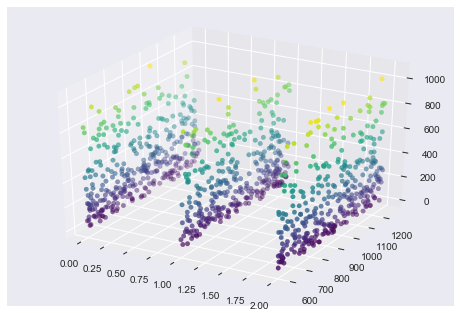

In [128]:
plot_data(X, y)

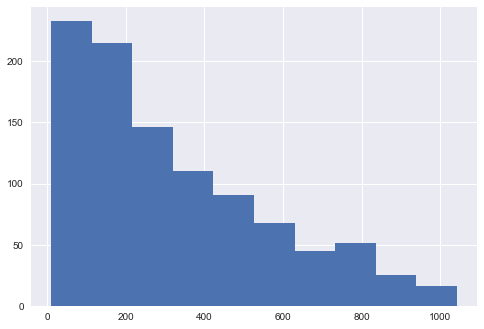

In [132]:
plt.hist(y)
plt.show()

# Model Evaluation

In [135]:
from model.gmm import GMM
from model.cgan import CGAN
from model.bayesnn import BayesNN
from model.mcdropout import MCDropout
from model.deepensemble import DeepEnsemble
from hyperopt.hyperopt import (hyperopt,
                               hyperopt_log,
                               hyperparam_plot,
                               performance_plot)
from visualisation.visualisation import (plot_surface,
                                         plot_prob_fixed,
                                         plot_violin,
                                         plot_prob_violin,
                                         plot_binned_violin)
from data.synthetic import plot_data

# Model: Gaussian Mixture Density Network

In [ ]:
params = {
    "x_features": 2,
    "y_features": 1,
    "epochs": 20000,
}
opt_params = {
    'n_components': [1,100],
    'n_hidden': [1,100],
}

gmm, best_params, best_vals, experiment, exp_model = hyperopt(
    GMM,
    params,
    opt_params,
    X, y,
    trials=30,
    val_split=0.8)

y_hat = gmm.predict(X)
plot_data(X, y_hat)

[INFO 07-14 14:17:18] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 07-14 14:17:18] ax.service.managed_loop: Started full optimization with 30 steps.
[INFO 07-14 14:17:18] ax.service.managed_loop: Running optimization trial 1...
[INFO 07-14 14:20:19] ax.service.managed_loop: Running optimization trial 2...
[INFO 07-14 14:22:38] ax.service.managed_loop: Running optimization trial 3...
[INFO 07-14 14:24:46] ax.service.managed_loop: Running optimization trial 4...
[INFO 07-14 14:27:12] ax.service.managed_loop: Running optimization trial 5...
[INFO 07-14 14:29:28] ax.service.managed_loop: Running optimization trial 6...
[INFO 07-14 14:32:05] ax.service.managed_loop: Running optimization trial 7...
[INFO 07-14 14:34:39] ax.service.managed_loop: Running optimization trial 8...
[INFO 07-14 

In [ ]:
print(f"n_components: {gmm.n_components}")
print(f"n_hidden: {gmm.n_hidden}")
display(hyperopt_log(experiment))
hyperparam_plot(exp_model, "n_components", "n_hidden")

In [ ]:
from performance.performance import prob_overlap, kl, js
p, q = prob_overlap(y, y_hat, bins=5)
print("fKL:", kl(p, q))
print("rKL:", kl(q, p))
print("JS:", js(p, q))

# Model: Conditional Generative Adversarial Network

In [ ]:
params = {
    "x_features": 2,
    "y_features": 1,
    "epochs": 20000,
}
opt_params = {
    'latent_dim': [1,100],
    'g_hidden': [1,100],
    'd_hidden': [1,100],
    'label_smooth': [0.0,1.0],
    'd_dropout': [0.0, 0.9],
    'gp_weight': [0.0, 1.0],
    'ds_weight': [0.0, 1.0],
}

cgan, best_params, best_vals, experiment, exp_model = hyperopt(
    CGAN,
    params,
    opt_params,
    X, y,
    trials=30,
    val_split=0.8)

y_hat = cgan.predict(X)
plot_data(X, y_hat)

In [ ]:
print(f"latent_dim: {cgan.latent_dim}")
print(f"g_hidden: {cgan.g_hidden}")
print(f"d_hidden: {cgan.d_hidden}")
print(f"label_smooth: {cgan.label_smooth}")
print(f"d_dropout: {cgan.d_dropout}")
print(f"gp_weight: {cgan.gp_weight}")
print(f"ds_weight: {cgan.ds_weight}")

display(hyperopt_log(experiment))
hyperparam_plot(exp_model, "g_hidden", "d_hidden")
hyperparam_plot(exp_model, "label_smooth", "d_dropout")
hyperparam_plot(exp_model, "gp_weight", "ds_weight")

In [ ]:
from performance.performance import prob_overlap, kl, js
p, q = prob_overlap(y, y_hat, bins=5)
print("fKL:", kl(p, q))
print("rKL:", kl(q, p))
print("JS:", js(p, q))

# Model: Bayesian Neural Network

In [ ]:
from model.bayesnn import BayesNN
from hyperopt.hyperopt import hyperopt
from hyperopt.hyperopt import hyperopt_log, hyperparam_plot, performance_plot

params = {
    "x_features": 2,
    "y_features": 1,
    "epochs": 2000,
}
opt_params = {
    'n_hidden': [1,100],
    'n_layers': [1,10],
}

bayesnn, best_params, best_vals, experiment, exp_model = hyperopt(
    BayesNN,
    params,
    opt_params,
    X, y,
    trials=30,
    val_split=0.8)

y_hat = bayesnn.predict(X)
plot_data(X, y_hat)

In [ ]:
print(f"n_hidden: {bayesnn.n_hidden}")
print(f"n_layers: {bayesnn.n_layers}")

display(hyperopt_log(experiment))
hyperparam_plot(exp_model, "n_hidden", "n_layers")

In [ ]:
from performance.performance import prob_overlap, kl, js
p, q = prob_overlap(y, y_hat, bins=5)
print("fKL:", kl(p, q))
print("rKL:", kl(q, p))
print("JS:", js(p, q))

# Model: Monte Carlo Dropout

In [ ]:
from model.mcdropout import MCDropout
from hyperopt.hyperopt import hyperopt
from hyperopt.hyperopt import hyperopt_log, hyperparam_plot, performance_plot

params = {
    "x_features": 2,
    "y_features": 1,
    "epochs": 2000,
}
opt_params = {
    'n_hidden': [1,100],
    'dropout': [0.1,0.9],
}

mcdropout, best_params, best_vals, experiment, exp_model = hyperopt(
    MCDropout,
    params,
    opt_params,
    X, y,
    trials=30,
    val_split=0.8)

y_hat, y_std = mcdropout.predict(X, return_std=True)
y_hat = mcdropout.predict(X)
plot_data(X, y_hat)

In [ ]:
print(f"n_hidden: {mcdropout.n_hidden}")
print(f"dropout: {mcdropout.dropout}")

display(hyperopt_log(experiment))
hyperparam_plot(exp_model, "n_hidden", "dropout")

In [ ]:
from performance.performance import prob_overlap, kl, js
p, q = prob_overlap(y, y_hat, bins=5)
print("fKL:", kl(p, q))
print("rKL:", kl(q, p))
print("JS:", js(p, q))

# Model: Deep Ensemble

In [ ]:
from model.deepensemble import DeepEnsemble
from hyperopt.hyperopt import hyperopt
from hyperopt.hyperopt import hyperopt_log, hyperparam_plot, performance_plot

params = {
    "x_features": 2,
    "y_features": 1,
    "epochs": 2000,
}
opt_params = {
    'n_hidden': [1,100],
    'dropout': [0.1,0.5],
}

deepensemble, best_params, best_vals, experiment, exp_model = hyperopt(
    DeepEnsemble,
    params,
    opt_params,
    X, y,
    trials=30,
    val_split=0.8)

y_hat, y_std = deepensemble.predict(X, return_std=True)
plot_data(X, y_hat)

In [ ]:
print(f"n_hidden: {deepensemble.n_hidden}")
print(f"dropout: {deepensemble.dropout}")

display(hyperopt_log(experiment))
hyperparam_plot(exp_model, "n_hidden", "dropout")

In [ ]:
from performance.performance import prob_overlap, kl, js
p, q = prob_overlap(y, y_hat, bins=5)
print("fKL:", kl(p, q))
print("rKL:", kl(q, p))
print("JS:", js(p, q))